In [1]:
#Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Find all CSV files in the working directory
csv_files = glob.glob("*.csv")

# Initialize an empty list to store DataFrames
dfs = []

# Loop through all CSV files and read them into DataFrames
for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged.csv", index=False)

print("CSV files have been successfully merged into 'merged.csv'")

# creating a dataframe from the merged data
df = pd.read_csv('C:\\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\merged.csv', low_memory=False)

CSV files have been successfully merged into 'merged.csv'


In [3]:
#Call the info method on df to see a summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             280901 non-null  int64  
 1   country                280833 non-null  object 
 2   description            280901 non-null  object 
 3   designation            197701 non-null  object 
 4   points                 280901 non-null  int64  
 5   price                  258210 non-null  float64
 6   province               280833 non-null  object 
 7   region_1               234594 non-null  object 
 8   region_2               111464 non-null  object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                280900 non-null  object 
 13  winery                 280901 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [4]:
#Call the head method on df to print the first several rows of the data
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
#Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of 
#df as well as the percentages (using `.mean()` instead of `.sum()`).
#Order them (increasing or decreasing) using sort_values
#Call `pd.concat` to present these in a single table (DataFrame) with the helpful column names 'count' and '%'
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Unnamed: 0,0,0.000000
description,0,0.000000
points,0,0.000000
winery,0,0.000000
variety,1,0.000356
country,68,0.024208
province,68,0.024208
price,22691,8.077935
region_1,46307,16.485167
designation,83200,29.618976


There are a number of columns here that are missing a significant amount (> 50%) of data, specifically the title (which is the name and vintage of the wine), region_2 (a secondary designetion of the region where the wine was produced), taster_name (the persone who did the review) and taster_twitter_handle. The designation is also missing nearly 30% of its values, and region_1 is missing more than 16%. The price column, which is critical to answering the business question, is missing roughly 8% of its data. A determination will need to be made, in line with the business problem, if these columns can or should be dropped.

In [6]:
#Let's see if all the entries are unique or if there might be duplicates. We'll use the description 
#label to make that determiniation.
df['description'].value_counts().head()

A little bit funky and unsettled when you pop the screwcap, but soon it finds its floral, blueberry base. Remains superficial and sweet in the mouth, with candied flavors, vanilla and mild oak. Highly regular; could use more concentration and density.    7
A dusty, cigar-smoke character on the nose of this blend of 52% Syrah and 48% Cabernet Sauvignon spices up aromas of strawberry fruit and rotting roses. The palate combines complex cranberry fruits with Kalamata olive, thyme and pencil lead.              6
This is very light, in both flavor and body. The aromas are earthy, with a faint suggestion of blackberries, and the mouthfeel is thin. These aren't terrible flaws, but the wine just lacks substance.                                                        6
92-94 Barrel sample. A rounded wine, its tannins submerged into the ripe fruits. It feels soft, and there is just a bite of alcohol. The structure is soft, generous, opulent.                                                       

It appears that there are many duplicate rows to contend with.

In [7]:
#Are there still duplicates if we take the price column into account?
df1 =  df.astype({'price':'str'})
(df1['price'] + ', ' + df['description']).value_counts().head()

40.0, A dusty, cigar-smoke character on the nose of this blend of 52% Syrah and 48% Cabernet Sauvignon spices up aromas of strawberry fruit and rotting roses. The palate combines complex cranberry fruits with Kalamata olive, thyme and pencil lead.                                                                                                                       6
nan, A fine and impressively complex wine, rich, packed with sultanas and dark chocolate. Very firm, this is worth aging but drinkable now.                                                                                                                                                                                                                                   6
70.0, Possibly just in a sullen phase, this reserve bottling from Craggy's home vineyard is dominated for the moment by smoke and cedar on the nose, and while there is some cherry fruit apparent in the mouth, it doesn't appear to be fully expressing itself. The im

Yes, still many duplicates.

In [8]:
#Because the varietal determines if we are talking about red, white, or dessert wines we need to see 
#the breakdown of varieties.
df['variety'].value_counts()

Pinot Noir                  27563
Chardonnay                  26235
Cabernet Sauvignon          22272
Red Blend                   19008
Bordeaux-style Red Blend    14262
                            ...  
Kotsifali                       1
Petit Courbu                    1
Misket                          1
Babosa Negro                    1
Carnelian                       1
Name: variety, Length: 756, dtype: int64

The data looks to be overwhelmingly red varietals.

In [9]:
#How many different varietals are we actually dealing with?
df['variety'].nunique()

756

In [10]:
#It's also worth looking at the statistics for the points column.

df['points'].describe()

count    280901.000000
mean         88.146934
std           3.151528
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [11]:
# Group by 'points' and calculate the count
grouped = df.groupby('points').size().reset_index(name='count')

# Calculate the total number of rows
total_rows = len(df)

# Calculate the percentage of total for each unique value
grouped['%'] = (grouped['count'] / total_rows) * 100

# Sort by 'count' in descending order
grouped = grouped.sort_values(by='count', ascending=False)

# Reset the index and drop the old index
grouped.reset_index(drop=True, inplace=True)

print(grouped)

    points  count          %
0       87  37680  13.413979
1       88  35078  12.487674
2       90  31383  11.172264
3       86  28173  10.029512
4       89  25147   8.952264
5       85  21941   7.810937
6       91  21895   7.794561
7       92  18854   6.711973
8       84  17188   6.118882
9       93  12506   4.452102
10      83   9073   3.229964
11      94   7220   2.570301
12      82   5877   2.092196
13      95   3251   1.157347
14      81   2194   0.781058
15      80   1295   0.461017
16      96   1218   0.433605
17      97    594   0.211462
18      98    208   0.074047
19      99     83   0.029548
20     100     43   0.015308


The most common score given to a wine is 87, followed by 88 and then 90. Given that the mean and median are each 88 this makes sense. It also makes sense to see the five lowest distributions are for the top scores of 96 through 100. Also unsurprising is that the lowest scores of 80 and 81 have relatively few entries. We can also look at this visually to get a better understanding.

<Axes: >

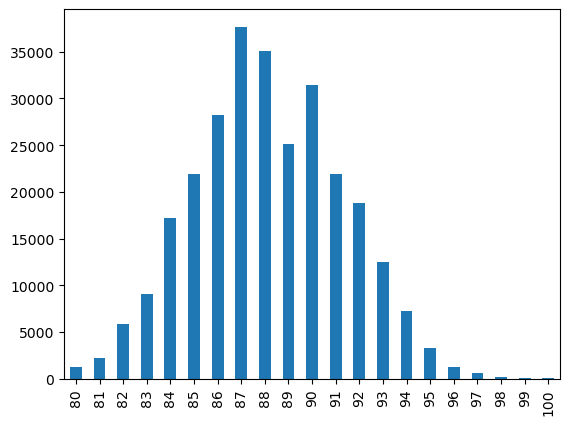

In [12]:
df['points'].value_counts().sort_index().plot.bar()

With the wine dataset, we can group by variety and look at either the summary statistics for all varieties' points and price or select the most popular and expensive ones.

In [21]:
# Groupby by variety
varietal = df.groupby("variety")

# Summary statistic of all varieties
varietal.describe().head()

Unnamed: 0                                                 \
                 count          mean           std      min       25%   
variety                                                                 
Abouriou           3.0  91176.666667  42686.435953  45401.0  71818.00   
Agiorgitiko      183.0  78795.748634  43320.525778    172.0  39709.50   
Aglianico        676.0  64348.621302  38453.232530     72.0  30862.25   
Aidani             2.0  44949.500000   3493.814606  42479.0  43714.25   
Airen              9.0  68056.777778  31279.372647  14295.0  50835.00   

                                          points             ...              \
                 50%        75%       max  count       mean  ...   75%   max   
variety                                                      ...               
Abouriou     98235.0  114064.50  129894.0    3.0  87.666667  ...  89.0  91.0   
Agiorgitiko  81483.0  114550.00  143213.0  183.0  86.016393  ...  88.0  92.0   
Aglianico    68569.5   94559.25  147760.0  676.0  88.933432  ...  91.0  97.0   
Aidani       44949.5   46184.75   47420.0    2.0  82.000000  ...  82.0  82.0   
Airen        56859.0   96459.00  105915.0    9.0  81.444444  ...  83.0  83.0   

             price                                                       
             count       mean        std   min   25%   50%   75%    max  
variety                                                                  
Abouriou       3.0  35.000000  34.641016  15.0  15.0  15.0  45.0   75.0  
Agiorgitiko  180.0  20.794444  11.057845   8.0  13.0  17.0  25.0   66.0  
Aglianico    553.0  36.209765  21.661998   6.0  20.0  30.0  45.0  180.0  
Aidani         2.0  27.000000   0.000000  27.0  27.0  27.0  27.0   27.0  
Airen          9.0   8.888889   0.781736   8.0   8.0   9.0   9.0   10.0  

[5 rows x 24 columns]

This selects the top 5 highest average points among all varieties:

In [23]:
varietal.mean().sort_values(by="points",ascending=False).head()

C:\Users\money\AppData\Local\Temp\ipykernel_30948\361683146.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  varietal.mean().sort_values(by="points",ascending=False).head()


,Unnamed: 0,points,price
variety,,,
Terrantez,31417.0,95.0,236.0
Tinta del Pais,69128.5,95.0,47.5
Riesling-Chardonnay,51348.0,94.0,40.0
Ramisco,107854.0,93.0,495.0
Blauburgunder,17191.5,93.0,19.0


This selects the top 5 highest average prices among all varieties:

In [24]:
varietal.mean().sort_values(by="price",ascending=False).head()

C:\Users\money\AppData\Local\Temp\ipykernel_30948\2014252805.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  varietal.mean().sort_values(by="price",ascending=False).head()


,Unnamed: 0,points,price
variety,,,
Ramisco,107854.000000,93.000000,495.000000
Terrantez,31417.000000,95.000000,236.000000
Francisa,122726.000000,91.000000,160.000000
Rosenmuskateller,32930.000000,92.500000,150.000000
Muscadel,84401.727273,92.454545,131.181818


<Axes: xlabel='points'>

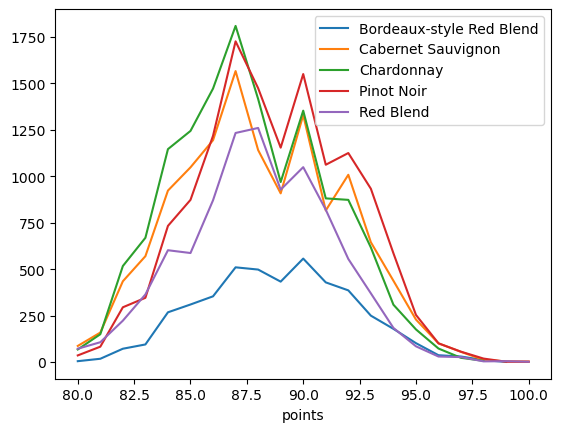

In [14]:
#A visual representation of the points by varietal might be helpful.
#Load a supplemental dataset containing the top five varietals. wine_counts counts the number of times 
#each of the possible review scores was received by the five most commonly reviewed types of wines.
wine_counts = pd.read_csv(r"C:\\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\top-five-wine-score-counts.csv", index_col=0)

#Plot the number of times a given number of points was awarded to each varietal.
wine_counts.plot.line()

The above chart shows us the most common scores for each varietal, which varietal has the most of a specific score (for example Chardonnay has the most 87s, but Pinot Noir has the most 90s. The lines also show that the scores fall into a roughly normal distribution.

In [15]:
#What about the price data? Let's look at the statistics around that column.

df['price'].describe()

count    258210.000000
mean         34.177162
std          38.611708
min           4.000000
25%          16.000000
50%          25.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64

It appears there is a large variation in price, from a minimum of 4 dollars to a maximum of 3300 dollars. It might also be worth noting that the mean is closer to the 75th quartile than the 50th quartile (median). We can look at the data visually as a histogram.

<Axes: ylabel='Frequency'>

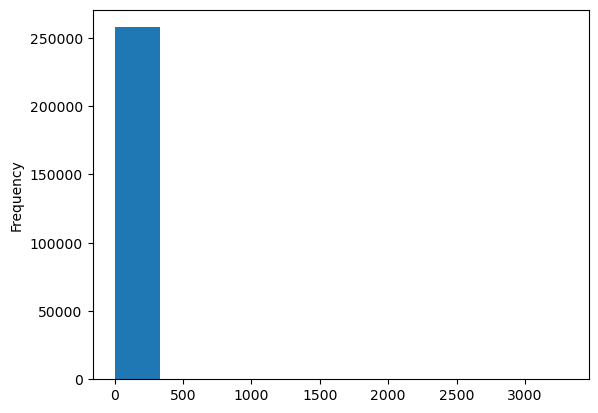

In [16]:
df['price'].plot.hist()

Because there are a number of outliers with very high prices this histogram is skewed. What if we limit the plot to bottles of wine under 100 dollars?

<Axes: ylabel='Frequency'>

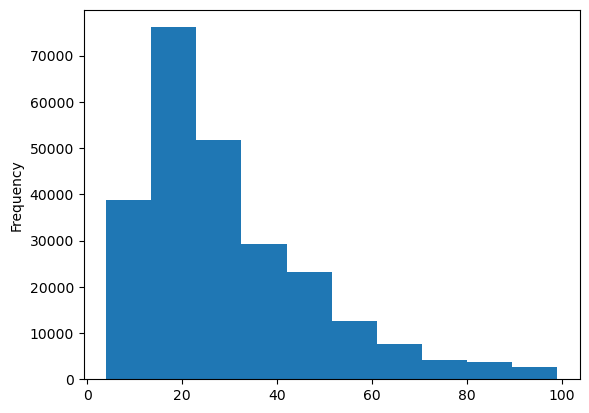

In [17]:
df[df['price'] < 100]['price'].plot.hist()

That looks better. It appears that many of the wines reviewed were in the 20 dollar range.

Let's look at some comparisons between the price and varietal type.

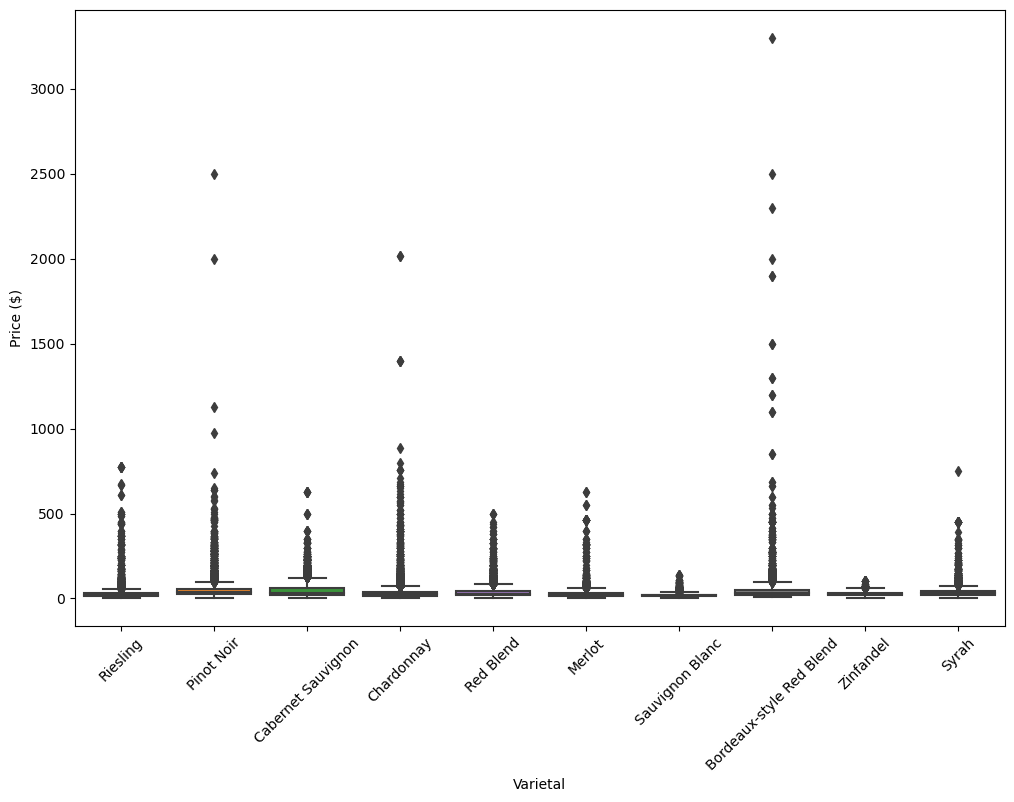

In [18]:
# Count the number of entries for each variety and get the top 10
top_varieties = df['variety'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only rows where 'variety' is in the list of top 10 varieties
filtered_df = df[df['variety'].isin(top_varieties)]

# Plot the boxplot using the filtered DataFrame
plt.figure(figsize=(12, 8))
sns.boxplot(x='variety', y='price', data=filtered_df)
plt.xticks(rotation=45)  #Rotate x-axis labels for better readability
plt.ylabel('Price ($)')
plt.xlabel('Varietal');

Because there are around 15 outliers that have a price in excess of $1,000 the boxplot isn't very useful. Let's see a boxplot that keeps us within 2 standard deviations of the mean.

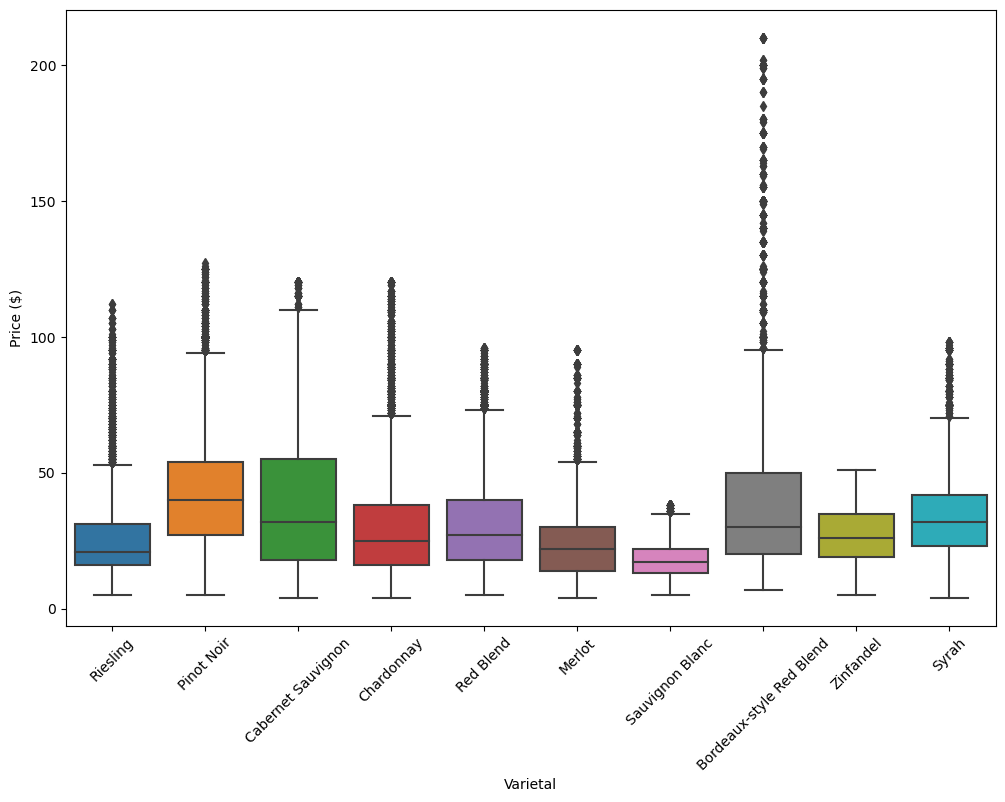

In [19]:
# Count the number of entries for each variety and get the top 10
top_varieties = df['variety'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only rows where 'variety' is in the list of top 10 varieties
filtered_df = df[df['variety'].isin(top_varieties)]

# Calculate the mean and standard deviation for each group
mean = filtered_df.groupby('variety')['price'].transform('mean')
std = filtered_df.groupby('variety')['price'].transform('std')

# Filter the DataFrame to include only rows where 'price' is within 2 standard deviations of the mean
filtered_df = filtered_df[(filtered_df['price'] >= (mean - 2 * std)) & (filtered_df['price'] <= (mean + 2 * std))]

# Plot the boxplot using the filtered DataFrame
plt.figure(figsize=(12, 8))
sns.boxplot(x='variety', y='price', data=filtered_df)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Price ($)')
plt.xlabel('Varietal');

That gives us an interesting look at the intersection of price and variety. We can see that for these top 10 varieites by count the lowest price is virtually the same. Pinot Noir has the highest mean price, but Bordeaux-style Red Blends have the highest overall price. Sauvignon Blanc has the lowest mean price. Both Chardonnay and Reisling (the other two white varieities in this boxplot) also have mean prices that are below all other varities. This begs the question of whether we might want to focus on red wines only?

Now let's look at some possible correlations between the price and the points.

<Axes: xlabel='price', ylabel='points'>

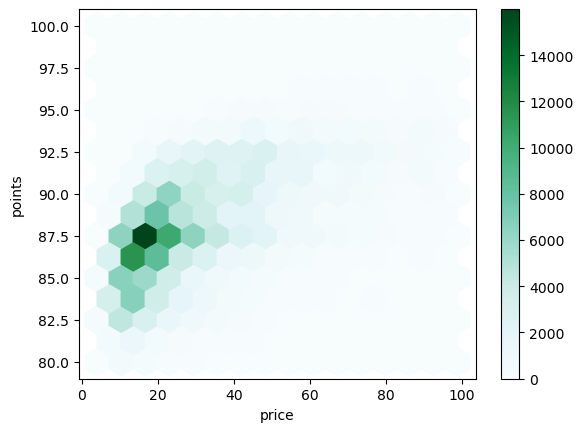

In [20]:
df[df['price'] < 100].plot.hexbin(x='price', y='points', gridsize=15)

We can see from this hexplot that the reviewed bottles of wine cluster around 87.5 points and around 20 dollars, confirming what we saw in our histogram above.

A word cloud can be a useful way to visualize the most important words within the description. Let's start with a simple example: using the first observation description as the input for the word cloud. 

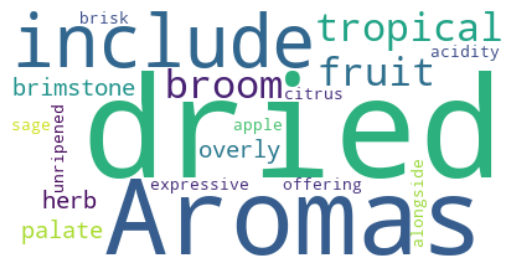

In [26]:
# Start with one review:
text = df.description[0]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Ok, now let's combine all the descriptions to get one huge word cloud that can give us information about the entire dataset of descriptions:

In [27]:
text = " ".join(review for review in df.description)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 68091643 words in the combination of all review.


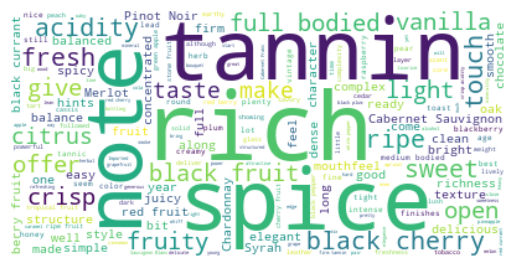

In [30]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors", "finish", "palate", "hint", "soft", "nose", "show", "dry", "aroma", "mouth", "end", "shows", "blend", "aromas"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud shows us that there are plenty of descriptors that we can use to look at connections between price and flavors. In the EDA phase we can refine this further through the use of embeddings or transformations.

# Data Cleaning

There are a number of steps that can be taken in cleaning up the data for further use. Here are my suggestions:
1. Change 'points' to 'Ratings'
1. Remove rows with empty 'price'. Rationale: We are looking at the connection between price and wine flavors. It's impossible to do so without a price, and there's no way for me to infer the price.
1. Remove rows with empty 'description'. Rationale: Similarly, we can't look at the connection between price and wine flavors if there's no description.
1. Remove any columns with more than 10% misssing values. This would be region_1 (16.5%), designation (29.6%), title (53.7%), region_2 (60.3%), taster_name (63.1%), and taster_twitter_handle (64.8%).
1. The data shows that the majority of wines rated, the majority of top rated wines, and the highest priced (mean) wines are all reds. This indicates that we might want to focus on red wine varietals. We could always go back later to perform the same analysis on white wine varietals. Removing white wine varietals will also trim the total number of varietals in the data set from the current 756. Wikipedia indicates there are ~364 white wine grape varietals.
1. Remove duplicates based on the description column